In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import cv2 as cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
tf.keras.backend.clear_session()
from sklearn.metrics import confusion_matrix, f1_score
warnings.filterwarnings('ignore')

## Load Images

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
df["id_code"] = df["id_code"].astype(str) + ".png"
label_map = dict(zip(df["id_code"], df["diagnosis"]))
dataset_path = 'colored_images'
X = []
y = []


In [4]:
df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [5]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):
        print(f"🔄 Loading images from {subfolder}...")

        for filename in tqdm(os.listdir(subfolder_path)):
            img_path = os.path.join(subfolder_path, filename)

          
            if filename in label_map:
                label = label_map[filename] 
                
                # Load gambar
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))  
                    X.append(img)
                    y.append(label) 

print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(y)}")

🔄 Loading images from Mild...


100%|██████████| 370/370 [00:00<00:00, 885.94it/s]


🔄 Loading images from Moderate...


100%|██████████| 999/999 [00:01<00:00, 873.46it/s]


🔄 Loading images from No_DR...


100%|██████████| 1805/1805 [00:01<00:00, 936.34it/s]


🔄 Loading images from Proliferate_DR...


100%|██████████| 295/295 [00:00<00:00, 885.09it/s]


🔄 Loading images from Severe...


100%|██████████| 193/193 [00:00<00:00, 803.11it/s]

Total images loaded: 3662
Total labels loaded: 3662


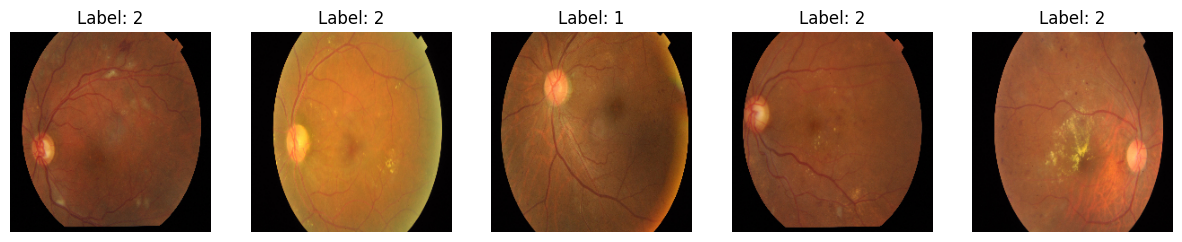

In [6]:
import random

random_indices = random.sample(range(len(X)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[index])
    plt.title(f"Label: {y[index]}")
    plt.axis('off')
plt.show()


In [7]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):  # Cek apakah benar-benar folder
        count = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])
        print(f'Jumlah gambar pada folder {subfolder}: {count}')

Jumlah gambar pada folder Mild: 370
Jumlah gambar pada folder Moderate: 999
Jumlah gambar pada folder No_DR: 1805
Jumlah gambar pada folder Proliferate_DR: 295
Jumlah gambar pada folder Severe: 193


## Splitting Data

In [8]:
X = np.array(X)
y = np.array(y)

X_train, X_remainingdata, y_train, y_remainingdata = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_remainingdata, y_remainingdata, test_size=0.25, random_state=42, stratify=y_remainingdata)

print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data validasi: {len(X_valid)}")
print(f"Ukuran data testing: {len(X_test)}")


Ukuran data training: 2197
Ukuran data validasi: 1098
Ukuran data testing: 367


In [9]:
print(X_train.shape)

(2197, 224, 224, 3)


In [10]:
from collections import Counter
print("\nDistribusi kelas :")
print("Training:", Counter(y_train))
print("Validation:", Counter(y_valid))
print("Testing:", Counter(y_test))


Distribusi kelas :
Training: Counter({0: 1083, 2: 599, 1: 222, 4: 177, 3: 116})
Validation: Counter({0: 541, 2: 300, 1: 111, 4: 88, 3: 58})
Testing: Counter({0: 181, 2: 100, 1: 37, 4: 30, 3: 19})


## Preprocessing Image


In [11]:
def preprocess_image(image):
    # Ekstrak green channel
    green_channel = image[:, :, 1]

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    enha = clahe.apply(green_channel)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(enha, (3, 3), sigmaX=0.5, sigmaY=0.5)

    # Konversi kembali ke 3 channel
    processed_image = cv2.merge([blurred, blurred, blurred])

    return processed_image


X_train_processed = np.array([preprocess_image(img) for img in X_train])
X_valid_processed = np.array([preprocess_image(img) for img in X_valid])
X_test_processed = np.array([preprocess_image(img) for img in X_test])

In [12]:
print("Shape X_train_processed:", X_train_processed.shape)
print("Shape X_valid_processed:", X_valid_processed.shape)
print("Shape X_test_processed:", X_test_processed.shape)

Shape X_train_processed: (2197, 224, 224, 3)
Shape X_valid_processed: (1098, 224, 224, 3)
Shape X_test_processed: (367, 224, 224, 3)


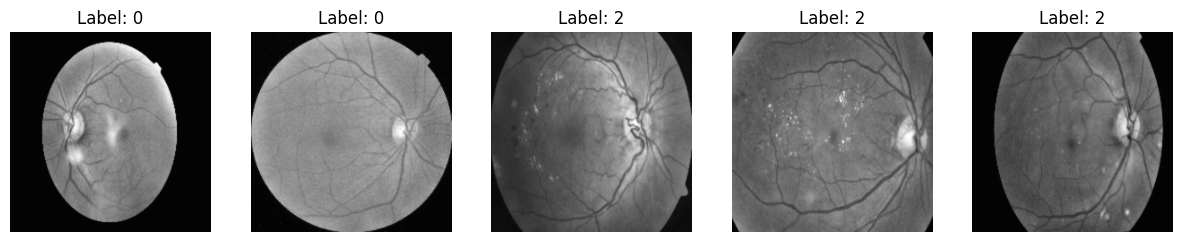

In [13]:
# Displaying sample preprocessed images
random_indices = random.sample(range(len(X_train_processed)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_processed[index])
    plt.title(f"Label: {y_train[index]}")
    plt.axis('off')
plt.show()


In [14]:
def circular_crop(image):
    height, width = image.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(center) - 15

    cv2.circle(mask, center, radius, 255, thickness=-1)

    circular_cropped_image = cv2.bitwise_and(image, image, mask=mask)

    return circular_cropped_image


X_train_cropped = np.array([circular_crop(img) for img in X_train_processed])
X_valid_cropped = np.array([circular_crop(img) for img in X_valid_processed])
#X_test_cropped = np.array([circular_crop(img) for img in X_test_processed])

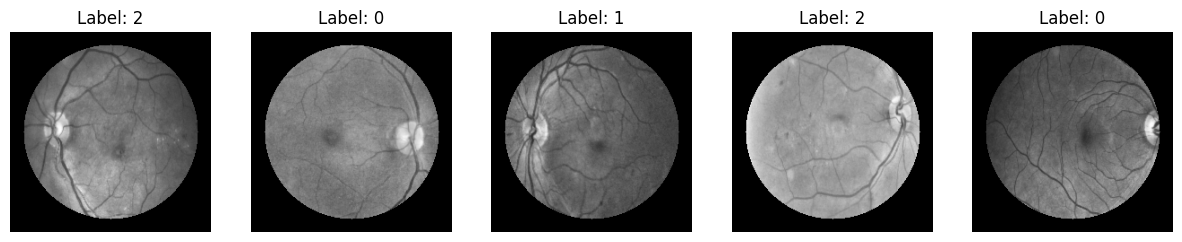

In [15]:
# Displaying sample preprocessed images
random_indices = random.sample(range(len(X_train_cropped)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_cropped[index])
    plt.title(f"Label: {y_train[index]}")
    plt.axis('off')
plt.show()


## Build Model ResNet50

In [16]:
n_class = 5

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(n_class, activation='softmax')(x)

adam = Adam(lr=0.00001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [17]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=n_class)
y_valid_one_hot = to_categorical(y_valid, num_classes=n_class)
y_test_one_hot = to_categorical(y_test, num_classes=n_class )

In [18]:
print(X_train_processed.shape)
print(y_train_one_hot.shape)
print(X_valid_processed.shape)
print(y_valid_one_hot.shape)

(2197, 224, 224, 3)
(2197, 5)
(1098, 224, 224, 3)
(1098, 5)


In [19]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3)
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [20]:
history = model.fit(X_train_processed,y_train_one_hot, epochs=20, batch_size=8, validation_data=(X_valid_processed, y_valid_one_hot), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
275/275 [==============================] - 16s 41ms/step - loss: 1.7351 - accuracy: 0.3487 - recall: 0.1866 - precision: 0.4197 - val_loss: 1.4158 - val_accuracy: 0.5164 - val_recall: 0.2368 - val_precision: 0.7407 - lr: 1.0000e-05
Epoch 2/20
275/275 [==============================] - 9s 34ms/step - loss: 1.2619 - accuracy: 0.5658 - recall: 0.3013 - precision: 0.7986 - val_loss: 1.2022 - val_accuracy: 0.6084 - val_recall: 0.3470 - val_precision: 0.7791 - lr: 1.0000e-05
Epoch 3/20
275/275 [==============================] - 9s 34ms/step - loss: 1.1137 - accuracy: 0.6372 - recall: 0.4260 - precision: 0.8425 - val_loss: 1.0964 - val_accuracy: 0.6421 - val_recall: 0.4636 - val_precision: 0.8157 - lr: 1.0000e-05
Epoch 4/20
275/275 [==============================] - 9s 34ms/step - loss: 1.0255 - accuracy: 0.6682 - recall: 0.4943 - precision: 0.8585 - val_loss: 1.0271 - val_accuracy: 0.6758 - val_recall: 0.5128 - val_precision: 0.8219 - lr: 1.0000e-05
Epoch 5/20
275/275 [===========

In [21]:
#model.save('model_resnet50_V2_noaugment.keras')

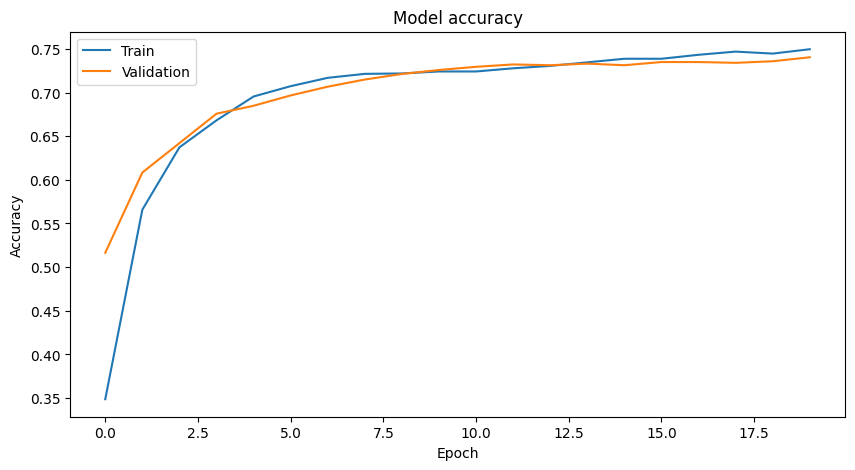

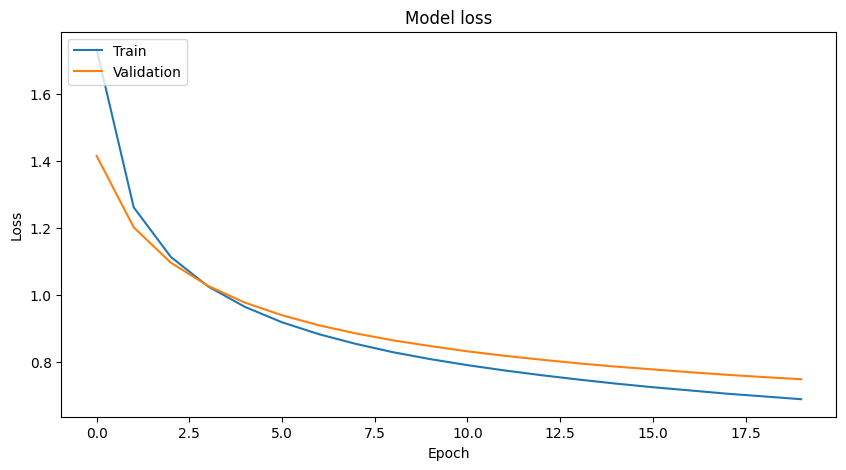

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
print(model.evaluate(X_test_processed, y_test_one_hot))

12/12 [==============================] - 1s 81ms/step - loss: 0.7494 - accuracy: 0.7302 - recall: 0.6049 - precision: 0.8284
[0.7494431734085083, 0.7302452325820923, 0.6049046516418457, 0.8283582329750061]


In [24]:
import numpy as np

print("Distribusi label Train:", np.unique(y_train, return_counts=True))
print("Distribusi label Validasi:", np.unique(y_valid, return_counts=True))
print("Distribusi label Test:", np.unique(y_test, return_counts=True))


Distribusi label Train: (array([0, 1, 2, 3, 4]), array([1083,  222,  599,  116,  177], dtype=int64))
Distribusi label Validasi: (array([0, 1, 2, 3, 4]), array([541, 111, 300,  58,  88], dtype=int64))
Distribusi label Test: (array([0, 1, 2, 3, 4]), array([181,  37, 100,  19,  30], dtype=int64))
